# Projet Python Data Science : Etude des données de la compétition SIAM 2007

## Nabil ZAIDI et Simon FREYBURGER

# Introduction générale

Nous avons choisi, pour notre projet Python Data Science, de nous intéresser à la problématique suivante : Comment faire du Machine Learning quand nous n'avons pas des nombres, mais des textes en entrée ? 
Nous avons donc tenté d'utiliser différentes méthodes de prédiction sur une base de données qui avait servi de sujet pour la compétition SIAM 2007. Il s'agissait de prédire les caractéristiques de différents relevés de communications du Service d'Enregistrement de la Sécurité Aéronautique américain.

L'enjeu principal de ces données a été la gestion des différences de distribution des présences/absences de label. Il fallait donc prêter une attention toute particulière à l'indicateur de précision (vrais positifs / faux positifs + vrais positifs) qui donnait un taux reflétant mieux l'efficacité de l'algorithme que l'indicateur absolu (taux de bonnes réponses)

In [4]:
#To manipulate DataFrames
import pandas as pd

#Plotting data
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram, linkage

#Math operations
import numpy as np
import scipy

#Machine Learning
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

#Metrics
from sklearn.metrics import precision_score # tp      / ( tp + fp )
from sklearn.metrics import accuracy_score  # tp + tn / ( tp + fp + tn + fn  ) 
from sklearn.metrics import recall_score    # tp      / ( tp + fn )

from sklearn.metrics import confusion_matrix

dict_score = {'precision' : precision_score, 'accuracy' : accuracy_score,\
              'recall score' : recall_score, \
              'confusion_matrix' : confusion_matrix}

#Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#word2vec
import gensim

#PCA
from sklearn.decomposition import PCA

#NLP
import re
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

stemmer = SnowballStemmer('english')
stop_w = set(stopwords.words("english"))
stop_w.update(stop_words.ENGLISH_STOP_WORDS)
stop = set([stemmer.stem(w) for w in stop_w])

#Google
dire = 'C:\\Users\\Simon\\Desktop\\hoodie\\Bilou\\'
import gensim as gs
google = gs.models.KeyedVectors.load_word2vec_format(dire + "GoogleNews-vectors-negative300.bin", binary=True)

In [37]:
from collections import Counter

In [5]:
#Retrieving files

dire = "C:\\Users\\Simon\\Desktop\\hoodie\\Bilou\\"

text_train = pd.read_csv(dire + 'texts.csv')
    
cat_train = pd.read_csv(dire + 'categories.csv')

text_test = pd.read_csv(dire + 'texts_test.csv')
    
cat_test = pd.read_csv(dire + 'categories_test.csv')

print("text entrainement : {}".format(text_train.shape))
print("cat entrainement  : {}".format(cat_train.shape))
print("text test  : {}".format(text_test.shape))
print("cat test   : {}".format(cat_test.shape))

text entrainement : (21519, 1)
cat entrainement  : (21519, 22)
text test  : (7077, 1)
cat test   : (7077, 22)


In [6]:
text_train.head()

,text
0,locate _ distancemeasuringequipment FROM runwa...
1,IN _ I BECAME AWARE THAT MY ULTRASONIC AND EDD...
2,visualflightrules FROM feet PIERCE flightlevel...
3,JUST PRIOR TO rotate A DEER RAN ONTO THE runwa...
4,climb ON _ degree head TO _ feet GOT traffical...


In [7]:
cat_train.head()
#We can see that for one text there can be multiple labels (text 2 : label 1, 12, 13...)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1,1,-1,-1,-1,1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
2,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,-1,1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Nettoyage des données

Une fois les données récupérées, on a besoin de les nettoyer. En effet :
<ul>
    <li>Les textes contiennent des caractères indésirables (ponctuations, etc...), certains mots sont en majuscules et d'autres en minuscules, ce qui pourrait mener à compter le même mot de 2 manières différentes. Aussi, certains mots n'apportent "rien" aux textes, ce sont les "stop words", nous allons donc les enlever. Enfin, les mots ayant le même radical, ont une signification très proche et peuvent donc être considérés comme similaires, on va donc utiliser un "stemmer". 
    On peut remarquer que certains mots sont collés, par exemple, "distancemeasuringequipment", dans un premier temps nous ne les traiterons pas, nous verrons cela ensuite.</li>
    <li>Les catégories se composent de -1 et 1, on va donc transformer les -1 en False (ou 0 c'est pareil) </li>
</ul>

In [8]:
def clean(t, stop = stop):
    #This function cleans a text t, by lowering the text, keeping only letter,
    #stemming each words and removing stop words and irrelevant words (those with length less than 3). )
    
    t = re.sub("[^a-z]"," ",t.lower())#keeping only letters
    l_t = t.split()
    new_l_t = []
    for w in l_t :
        #Stemmers remove morphological affixes from words.
        new_w = stemmer.stem(w)
        if len(new_w) > 3 and new_w not in stop :
            new_l_t.append(new_w)
    return ' '.join(new_l_t)

def preprocessing_train(train, clean = clean):
    #The first column, that should contains texts, is renamed 'text' and all texts are cleaned
    df = train.copy()
    col = df.columns[0]
    df[col] = df[col].apply(clean)
    df = df.rename(columns = {col : 'text'})
    return df

def preprocessing_test(test, clean = clean):
    #We replace -1 by False, it will be easier to use.
    df = test.copy()
    df = df.replace(-1,False)
    return df

X_train = preprocessing_train(text_train)
y_train = preprocessing_test(cat_train)
X_test = preprocessing_train(text_test)
y_test = preprocessing_test(cat_test)

## Aperçu des données

Pour analyser du texte, tout d'abord, nous allons les représenter en "bag of words". Cela va nous permettre de repérer les mots les plus importants, et ensuite de faire du Machine Learning dessus.

In [9]:
def create_bagofwords(list_text, max_feat = 5000):
    vectorizer = TfidfVectorizer(\
    #vectorizer = CountVectorizer(\
                                analyzer = "word",   \
                                tokenizer = None,    \
                                preprocessor = None, \
                                stop_words = None,   \
                                ngram_range=(1, 2),  \
                                 #We take words but also couples of words
                                token_pattern=r'\b\w+\b',\
                                max_features = max_feat)
    #Initialize the "vectorizer" object, which is our bag of words tool
    text_vectors = vectorizer.fit_transform( list_text ).toarray()
    #Creates the vectorizer and vectorizes the texts
    #We convert out vector to an array because it's easier, and faster to work with
    
    return vectorizer, text_vectors

### Tentative de caractérisation des labels

Une première difficulté de l'analyse de ce corpus de texte vient du fait que nous n'avons aucune idée de ce que représentent les différents labels. Ils pourraient être plus ou moins importants, plus ou moins facile à prédire etc...

Nous allons donc dans un premier temps essayer de représenter pour chaque label les mots qui le caractérisent. Étant donné qu'un texte peut avoir plusieurs labels, pour chaque label nous allons nous intéresser seulement aux textes qui sont labellisés uniquement par celui-ci. On aura alors plus de chance (ce sera plus simple) de comprendre les mots communs en particulier à ce label. Il faudra bien évidemment comparer cela avec les mots des autres labels pour comprendre si un mot apparaît souvent ou seulement dans un label. Lors de la création des bag of words nous avons utilisé le score TF-IDF, les mots présents dans tous les textes seront donc pénalisés, mais il faut néanmoins y prêter attention.

Les 20 mots les plus utilisés dans les   28 textes labelisés uniquement par 0 :


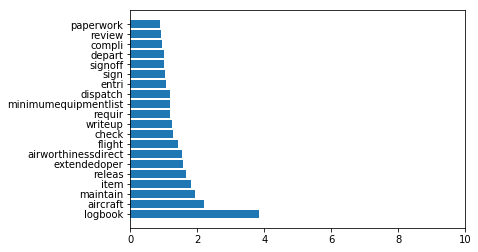

Les 20 mots les plus utilisés dans les 1603 textes labelisés uniquement par 1 :


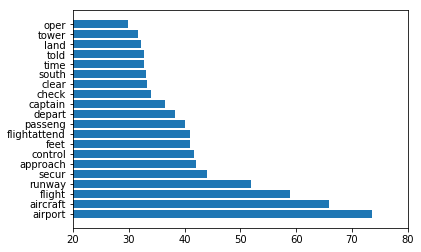

Les 20 mots les plus utilisés dans les   39 textes labelisés uniquement par 2 :


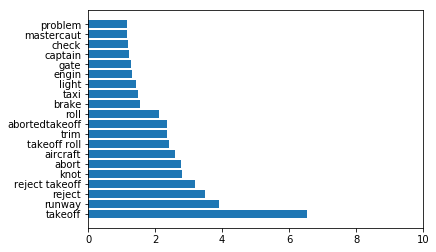

Les 20 mots les plus utilisés dans les   41 textes labelisés uniquement par 3 :


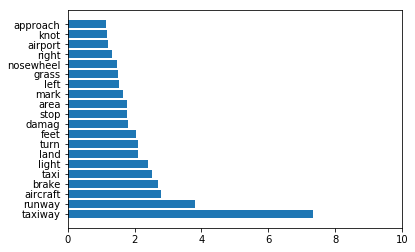

Les 20 mots les plus utilisés dans les  162 textes labelisés uniquement par 4 :


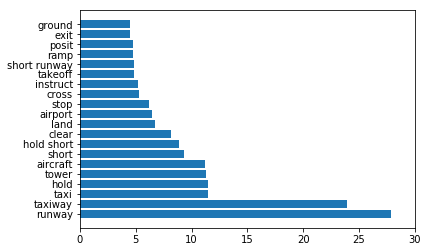

Les 20 mots les plus utilisés dans les  412 textes labelisés uniquement par 5 :


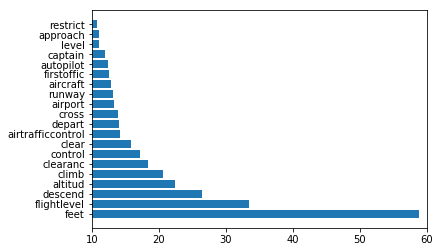

Les 20 mots les plus utilisés dans les   59 textes labelisés uniquement par 6 :


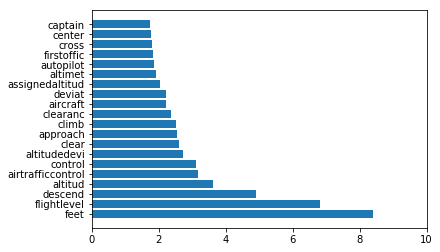

Les 20 mots les plus utilisés dans les   59 textes labelisés uniquement par 7 :


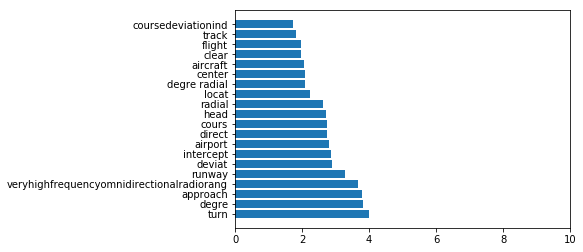

Les 20 mots les plus utilisés dans les   25 textes labelisés uniquement par 8 :


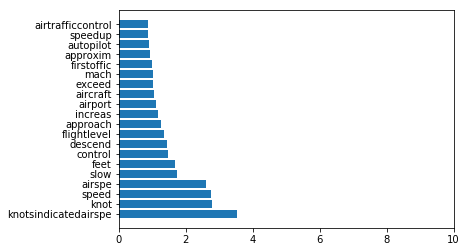

Les 20 mots les plus utilisés dans les   36 textes labelisés uniquement par 9 :


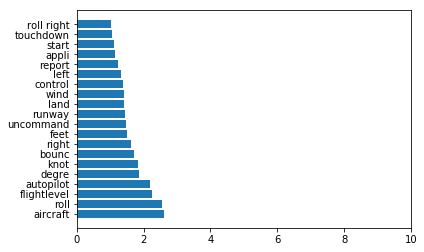

Les 20 mots les plus utilisés dans les   39 textes labelisés uniquement par 10 :


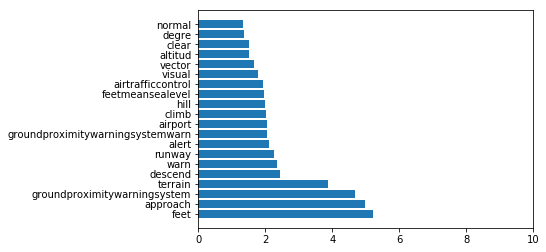

Les 20 mots les plus utilisés dans les  597 textes labelisés uniquement par 11 :


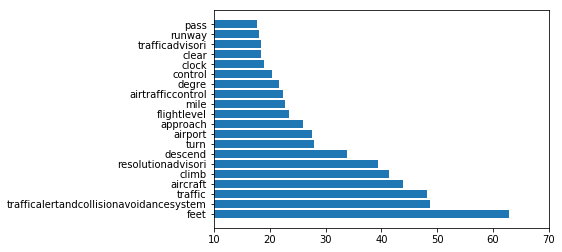

Les 20 mots les plus utilisés dans les  296 textes labelisés uniquement par 12 :


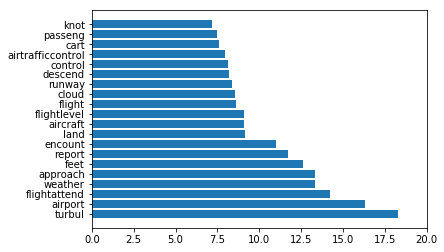

Les 20 mots les plus utilisés dans les   44 textes labelisés uniquement par 13 :


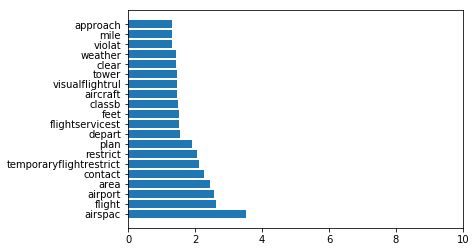

Aucun texte n'est labélisé uniquement par 14
Les 20 mots les plus utilisés dans les   51 textes labelisés uniquement par 15 :


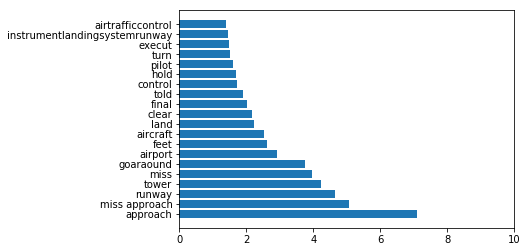

Les 20 mots les plus utilisés dans les   42 textes labelisés uniquement par 16 :


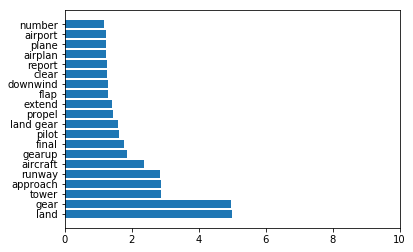

Les 20 mots les plus utilisés dans les  155 textes labelisés uniquement par 17 :


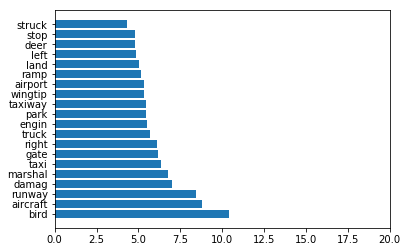

Les 20 mots les plus utilisés dans les 1887 textes labelisés uniquement par 18 :


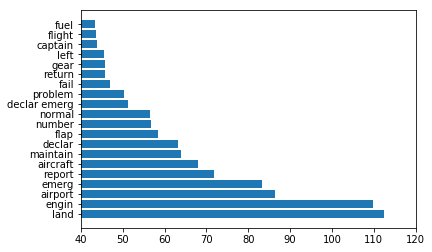

Les 20 mots les plus utilisés dans les   62 textes labelisés uniquement par 19 :


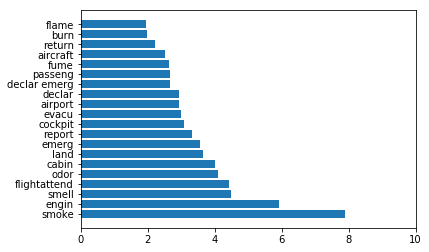

Les 20 mots les plus utilisés dans les  196 textes labelisés uniquement par 20 :


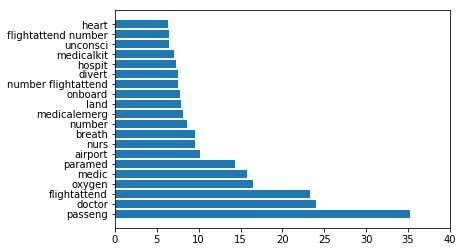

Les 20 mots les plus utilisés dans les  116 textes labelisés uniquement par 21 :


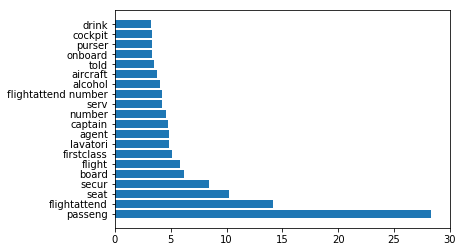

In [10]:
X_train['label'] = y_train.apply(lambda row : [int(k) for k in y_train.columns if row[k]], axis = 1)
#The column label contains, for each text, all his labels

def histogram(df,col = 0, n_words = 20):
    #n_words is number of words we want to plot
    df_plt = df.sort_values(by = col, ascending=False)
    df_plt = df_plt.iloc[:n_words,col]
    
    y_pos = np.arange(n_words)
    plt.barh(y_pos, list(df_plt), align='center')
    plt.yticks(y_pos, df_plt.index)
    plt.axis([10*int(min(df_plt)/10), 10*int(max(df_plt)/10+1),-1.39, 20.39])
    #If all values are superior to 1000, no need to show in the axis 0 to 1000.
    
    plt.show()
    
def best_words(df):
    #For each label, we will see what are the most important words that could caracterize this label
    
    vect, l_t = create_bagofwords(df['text'], max_feat = 5000)
    for v in y_train.columns :
        work = df[df['label'].apply(lambda x : x == [int(v)])]
        #To see what words caracterize a label we need to keep the texts that have only this label.
        w_t = [l_t[t] for t in work.index] #We retrieve the bag of words of these texts
        if w_t :
            sum_l = sum(w_t) #We sum the score of each word
            occurences = {w : sum_l[vect.vocabulary_[w]] for w in vect.vocabulary_}
            df_occ = pd.DataFrame(occurences, index = [0]).transpose()
            print("Les 20 mots les plus utilisés dans les {:>4} textes labelisés uniquement par {} :".format(len(w_t),v))
            histogram(df_occ)
        else :
            print("Aucun texte n'est labélisé uniquement par {}".format(v))

best_words(X_train)

#### Description de (certains) labels

On peut remarquer, dans un premier temps, qu'aucun texte n'est labelisé uniquement par 14, il sera donc surement difficile de bien prédire ce label, étant donné qu'on aura peu d'information pour caractériser ce label. En effet, les informations qu'on aura, seront un mélange de caractéristiques du label 14 et d'autres labels.

Dans un second temps, on peut remarquer, dans le même genre, que plusieurs labels n'ont que très peu de texte les "caractérisant".

Enfin, on peut avoir une idée, pour certains labels, de ce qu'ils représentent. Par exemple, le label 21 contient les mots "seat", "secur", "board", "lavatori", "alcohol", "drink", ce qui peut nous laisser penser que ces textes traitent des passagers et de leurs conditions de voyage.

In [11]:
print(X_train[X_train['label'].apply(lambda x : x == [21])].iloc[0]['text'])
print('\n')
print(X_train[X_train['label'].apply(lambda x : x == [21])].iloc[1]['text'])
#Our conclusion seems to be correct

passeng misconduct entrydoor close prior engin start flightattend number inform passeng aircraft went flightattend number malepasseng heat argument passeng later identifi airbas flightattend number advis passeng refus return seat violent newspap flightattend observ demonstr anger attitud passeng agre potentialproblem enrout safe passeng crew underway passeng leav aircraft stair bring passeng deplan


assist passeng midcabin section plane return galley complet cater check need cabin assist baggag leav rememb mallet credenza aisl midcabin approxim minut went galley notic mallet gone thought misplac help passeng went left cabin lavatori mallet lavatori credenza note write paper towel close lavatori door lock lavatori captain want know exact note open lavatori door pull note mallet touch mallet fingerprint necessari note bitch kill captain secur bomb bring flight left hour later went secur luggag snif coupl peopl suspect captain permit airplan


# Modèle de Machine Learning avec Bag of Words

La compréhension des différents labels s'avérant plutôt compliqué, nous allons tenter de voir si un algorithme de machine learning y arrive mieux que nous.

Nous aurons surement à essayer plusieurs modèles de classifeur, la fonction "create_model" va donc créer les bag of words, entrainer le classifieur et transformer l'échantillon test.

In [12]:
def create_model(classifier, X_train, y_train, X_test):
    #This function returns a vectorizer of bag of words, 
    #a trained classifier and the x_test ready to be predicted
    
    vect, x_train = create_bagofwords(X_train) #Bag of words
    classifier.fit(x_train,y_train) #We fit the train data
    x_test = vect.transform(X_test).toarray() #Transform the test data
    
    return vect, classifier, x_test

Nous avons vu que nous traitions un problème multi-label, car à un texte on peut associer plusieurs labels. On va donc tenter un premier algorithme de Machine Learning supportant le multi-label, le RandomForest.

Nous allons essayer avec 10, puis 50 et enfin 100 arbres afin de comparer les résultats.

In [13]:
#Multi-label classification

for n in [10,50,100] :
    model = RFC(n_estimators = n, n_jobs = -1)
    _,classifier, x_test = create_model(model,X_train['text'],y_train, X_test['text'])
    print('Pour {:>3} estimateurs on obtient un score de : {:4.3f}'.format(n,classifier.score(x_test,y_test)))

Pour  10 estimateurs on obtient un score de : 0.192
Pour  50 estimateurs on obtient un score de : 0.216
Pour 100 estimateurs on obtient un score de : 0.220


Ici, on s'intéresse au score "accuracy", défini par : $\frac{\text{nombre de bonnes réponses}}{\text{total}}$.

Si les résultats augmentent avec le nombre d'estimateurs, l'amélioration est très légère, et ils sont encore très faibles.

On va donc essayer de prédire label par label, et ensuite réunir les résultats. Soit on obtiendra un score plus élevé, soit on pourra peut-être voir les labels que l'on prédit mal.

In [14]:
model = RFC(n_estimators = 50, n_jobs = -1)
#50 is an arbitrary value, not too small to have better results but not too high because we have 22 model to train.

values = y_train.columns

predicted = []

for v in values :
    _,classifier, x_test = create_model(model, X_train['text'], y_train[v], X_test['text'])
    y_predicted = classifier.predict(x_test)
    
    predicted.append(y_predicted)
    
    print('Pour la valeur : {:>2}, on obtient un score de : {:4.3f}'\
          .format(v, accuracy_score(y_test[v],y_predicted)))

Pour la valeur :  0, on obtient un score de : 0.955
Pour la valeur :  1, on obtient un score de : 0.639
Pour la valeur :  2, on obtient un score de : 0.984
Pour la valeur :  3, on obtient un score de : 0.975
Pour la valeur :  4, on obtient un score de : 0.937
Pour la valeur :  5, on obtient un score de : 0.806
Pour la valeur :  6, on obtient un score de : 0.915
Pour la valeur :  7, on obtient un score de : 0.912
Pour la valeur :  8, on obtient un score de : 0.976
Pour la valeur :  9, on obtient un score de : 0.938
Pour la valeur : 10, on obtient un score de : 0.984
Pour la valeur : 11, on obtient un score de : 0.920
Pour la valeur : 12, on obtient un score de : 0.901
Pour la valeur : 13, on obtient un score de : 0.963
Pour la valeur : 14, on obtient un score de : 0.970
Pour la valeur : 15, on obtient un score de : 0.957
Pour la valeur : 16, on obtient un score de : 0.980
Pour la valeur : 17, on obtient un score de : 0.955
Pour la valeur : 18, on obtient un score de : 0.857
Pour la vale

On remarque alors que pour la plupart des labels les scores sont très bons, on va donc voir si en multi-label le résultat est encore aussi bon.

In [15]:
df_predicted_1 = pd.DataFrame(predicted).transpose()
df_predicted_1.columns = y_test.columns

print("Le score pour la classification multi-label,\
obtenu en concatenant les différentes classifications par label est de : {:>4.03f}".\
format(accuracy_score(y_test,df_predicted_1)))

Le score pour la classification multi-label,obtenu en concatenant les différentes classifications par label est de : 0.234


Le résultat est légèrement amélioré par rapport à la classification multi-label, mais reste néanmoins très bas.

Pourquoi, alors que la prédiction label par label paraît satisfaisante, la prédiction multi-label est de faible qualité ?

Une des réponses possibles est que l'on considère le score "accuracy". Donc, si les données sont déséquilibrées  ("imbalanced") et donc si par exemple on a très peu de positif et beaucoup de négatif pour un label, alors un classifieur qui prédit toujours négatif aura une "accuracy" élevée, mais ne sera pas bon pour autant : si on prend l'exemple des fraudes, le principe même est qu'il y en a très peu et qu'il faut les trouver...

In [16]:
#How imbalanced is the training set ?

for v in y_train.columns :
    true_train = y_train[v].sum()
    
    print('Pour la valeur : {:>2}, on obtient un ratio de : {:>5.0f} / {:>5.0f}'\
          .format(v, true_train, y_train.shape[0]))

Pour la valeur :  0, on obtient un ratio de :  1441 / 21519
Pour la valeur :  1, on obtient un ratio de : 12876 / 21519
Pour la valeur :  2, on obtient un ratio de :   393 / 21519
Pour la valeur :  3, on obtient un ratio de :   428 / 21519
Pour la valeur :  4, on obtient un ratio de :  3062 / 21519
Pour la valeur :  5, on obtient un ratio de :  6065 / 21519
Pour la valeur :  6, on obtient un ratio de :  1684 / 21519
Pour la valeur :  7, on obtient un ratio de :  2213 / 21519
Pour la valeur :  8, on obtient un ratio de :   405 / 21519
Pour la valeur :  9, on obtient un ratio de :  1107 / 21519
Pour la valeur : 10, on obtient un ratio de :   353 / 21519
Pour la valeur : 11, on obtient un ratio de :  3357 / 21519
Pour la valeur : 12, on obtient un ratio de :  2162 / 21519
Pour la valeur : 13, on obtient un ratio de :  1261 / 21519
Pour la valeur : 14, on obtient un ratio de :   325 / 21519
Pour la valeur : 15, on obtient un ratio de :   935 / 21519
Pour la valeur : 16, on obtient un ratio

On constate donc clairement que pour la plupart des labels, l'échantillon d'entraînement est déséquilibré. On va donc tenter de résoudre ce déséquilibre en ne prenant, pour chaque label, qu'une partie de l'échantillon d'entraînement négatif afin d'avoir légèrement plus de négatifs que de positifs.

Nous allons en particulier utiliser deux autres scores, la "precision", définie par $\frac{tp}{tp+fp}$ et le "recall score", défini par $\frac{tp}{tp+fn}$. Nous utiliserons aussi les matrices de confusion pour avoir une vision "neutre" des résultats.

In [17]:
model = RFC(n_estimators = 50, n_jobs = -1)
#50 is an arbitrary value, not too small to have better results but not too high because we have 22 model to train.

def multilabel_class(X_train, Y_train, X_test, Y_test, model = model):
    values = Y_train.columns
    false_rate = 1.5 #Arbitrary value : Since the training set is imbalanced,
    #we will keep only, approximatively, 1.2 more negatives examples than positives in the training set.
    
    dict_prediction = {}
    scores = {}
    
    predicted = []
    
    for v in values :
        
        y = Y_train[v]
        x_true = X_train[ y == 1]
        x_false = X_train[ y == 0]
        
        y_predicted = []
        y_score = 0
        x_train = pd.concat([x_true,\
                             x_false.sample(min(int(y.sum()*false_rate), x_false.shape[0]))])
        y_train = y.loc[x_train.index]
        
        _,classifier, x_test = create_model(model, x_train['text'], y_train, X_test['text'])
        
        dict_prediction[v] = {}
        dict_prediction[v]['classifier'] = classifier
        dict_prediction[v]['to predict'] = x_test
        dict_prediction[v]['predicted'] = classifier.predict(x_test)
        dict_prediction[v]['true label'] = Y_test[v]
        
        scores[v] = {}
        for name,score in dict_score.items() :
            scores[v][name] = score(Y_test[v],dict_prediction[v]['predicted'])
        print('Valeur {:>2} effectuée'.format(v))
            
    return scores, dict_prediction

scores, dict_prediction = multilabel_class(X_train, y_train, X_test, y_test)
scores = pd.DataFrame(scores).transpose()

Valeur  0 effectuée
Valeur  1 effectuée
Valeur  2 effectuée
Valeur  3 effectuée
Valeur  4 effectuée
Valeur  5 effectuée
Valeur  6 effectuée
Valeur  7 effectuée
Valeur  8 effectuée
Valeur  9 effectuée
Valeur 10 effectuée
Valeur 11 effectuée
Valeur 12 effectuée
Valeur 13 effectuée
Valeur 14 effectuée
Valeur 15 effectuée
Valeur 16 effectuée
Valeur 17 effectuée
Valeur 18 effectuée
Valeur 19 effectuée
Valeur 20 effectuée
Valeur 21 effectuée


In [18]:
old_scores = {}
for v in y_test.columns :
    old_scores[v] = {}
    for name,score in dict_score.items() :
            old_scores[v][name] = score(y_test[v],df_predicted_1[v])
old_scores = pd.DataFrame(old_scores).transpose()

In [19]:
old_scores

,accuracy,confusion_matrix,precision,recall score
0,0.9545,"[[6575, 67], [255, 180]]",0.728745,0.413793
1,0.638689,"[[1681, 2099], [458, 2839]]",0.574929,0.861086
10,0.98375,"[[6900, 16], [99, 62]]",0.794872,0.385093
11,0.919881,"[[5960, 199], [368, 550]]",0.734312,0.599129
12,0.901088,"[[6169, 221], [479, 208]]",0.484848,0.302766
13,0.96312,"[[6644, 40], [221, 172]]",0.811321,0.437659
14,0.970468,"[[6862, 32], [177, 6]]",0.157895,0.0327869
15,0.95662,"[[6722, 41], [266, 48]]",0.539326,0.152866
16,0.979652,"[[6901, 14], [130, 32]]",0.695652,0.197531
17,0.954642,"[[6662, 64], [257, 94]]",0.594937,0.267806


In [20]:
scores

,accuracy,confusion_matrix,precision,recall score
0,0.940229,"[[6255, 387], [36, 399]]",0.507634,0.917241
1,0.646743,"[[1724, 2056], [444, 2853]]",0.581177,0.865332
10,0.892751,"[[6185, 731], [28, 133]]",0.153935,0.826087
11,0.906316,"[[5643, 516], [147, 771]]",0.599068,0.839869
12,0.869012,"[[5655, 735], [192, 495]]",0.402439,0.720524
13,0.932881,"[[6270, 414], [61, 332]]",0.44504,0.844784
14,0.872686,"[[6080, 814], [87, 96]]",0.105495,0.52459
15,0.879186,"[[5941, 822], [33, 281]]",0.25476,0.894904
16,0.900805,"[[6236, 679], [23, 139]]",0.169927,0.858025
17,0.866893,"[[5845, 881], [61, 290]]",0.247652,0.826211


In [29]:
labels_predicted = []
for v in y_train.columns:
    labels_predicted.append(dict_prediction[v]['predicted'])

labels_predicted = pd.DataFrame(labels_predicted).transpose()

print('Pour {} estimateurs on obtient un score de : {:4.3f}'.format(50,accuracy_score(y_test, labels_predicted)))


Pour 50 estimateurs on obtient un score de : 0.122


## Conclusion du modèle de Machine Learning avec Bag of Words

Les résultats sont plutôt décevants. Si on arrive à améliorer les résultats de la classification multi-label en effectuant quelques optimisations simples, le gain reste très léger.

L'approche par les bag of words ne semble donc pas particulièrement efficace dans ce contexte. Nous allons donc essayer une approche par word2vec.

# Modèle de Machine Learning avec Word2vec "simpliste"

L'approche "bag of words" consiste à résumer un texte en un vecteur. Cela peut sembler assez réducteur dans le sens où l'on perd complètement le sens des mots : on ne s'occupe que de leur occurrence.

L'approche "word2vec", elle, permet de prendre en compte le sens des mots en associant à chaque mot un vecteur, ce qui permet à l'ordinateur de le positionner par rapport aux autres mots, et d'en déduire une sorte de "sens"

Pour cela, il faut transformer les phrases en liste de mots, puis récupérer dans une liste l'ensemble des phrases transformées en liste.

On va donc créer une classe Text2vec() qui prendra en paramètre une liste de textes et qui renverra un objet contenant le model word2vec que l'on a entraîné, et qui transformera les mots des futurs textes en vecteurs.

Dans cette partie on considèrera que le vecteur représentant un texte est la somme des Word2vec de chaque mot.

In [23]:
class Text2vec():
    def __init__(self, list_text):
        self.model = gensim.models.Word2Vec(self.lines(list_text))
    
    def lines(self, list_text):
        #We transform a list of text into a list of phrases, where phrases are a list of words.
        return [phrase.split() for text in list_text for phrase in text.split('.') if len(phrase)>3]
    
    def word2vec(self,word):
        #Transform a word into a word2vec.
        #If the word is not known by our model the function returns a vector with zeros.
        if word in self.model.wv.vocab.keys() :
            res = self.model.wv.word_vec(word)
        else :
            res = np.zeros(self.model.vector_size)
        return res
    
    def transform_text(self,text):
        #Takes in parameter a text and return a vector, that is the sum of all word2vec.
        l_word = text.split()
        l_vec = [self.word2vec(w) for w in l_word]
        text_vec = np.sum(l_vec,0)
        return text_vec
    
    def transform(self,list_text):
        return [self.transform_text(t) for t in list_text]

In [24]:
def clean_w2v(t, stop = stop):
    t = re.sub("[^a-z.]"," ",t.lower())#keeping only letters and '.' since we need to split by phrases.
    l_t = t.split('.')
    new_l_t = []
    for phrase in l_t :
        new_phrase = []
        for w in phrase.split():
            #Stemmers remove morphological affixes from words
            new_w = stemmer.stem(w)
            if len(new_w) > 3 and new_w not in stop :
                new_phrase.append(new_w)
        if new_phrase :
            new_l_t.append(' '.join(new_phrase))
    return '.'.join(new_l_t)

In [25]:
X_train_w2v = preprocessing_train(text_train, clean = clean_w2v)
y_train_w2v = y_train.copy()
X_test_w2v = X_test.copy()
y_test_w2v = y_test.copy()

In [26]:
n_est = 50
rfc = RFC(n_estimators=n_est, n_jobs = -1)

t2v = Text2vec(X_train_w2v['text'])
x_train = t2v.transform(X_train_w2v['text'])
rfc.fit(x_train,y_train_w2v)
x_test = t2v.transform(X_test_w2v['text'])
print('Pour {} estimateurs on obtient un score de : {:4.3f}'.format(n_est,rfc.score(x_test,y_test)))

Pour 50 estimateurs on obtient un score de : 0.231


## Conclusion du modèle de Machine Learning avec Word2vec "simpliste"

Conclusion  Le score est donc sensiblement le même que les scores des résultats précédents (avec 50 estimateurs : 0,231 et 0.211). Le passage aux Word2vec n'est donc pas suffisant. Néanmoins, il est vrai que notre hypothèse de considérer le vecteur d'un texte comme la somme des word2vec de ses mots est très simpliste.

Nous avons donc essayé une autre manière de modéliser un texte par un vecteur à l'aide des Word2vec.

# Modèle de Machine Learning avec Word2vec, ACP et classification

## Préprocessing word2vec

L'idée générale de ce préprocessing est de récupérer la position de chacun des mots du texte au sein du dictionnaire word2vec construit par google, puis de traiter celles-ci pour pouvoir appliquer des algorithmes de machine learning.

Le traitement consistera, notamment, en une ACP, afin de réduire la taille de chacun des vecteurs, puis une classification, pour ne récupérer que les éléments les plus caractéristiques de chaque classe. 

Chaque texte est donc finalement représentés par les vecteurs (de dimension 10, valeur arbitraire choisie pour la suite) des centres de gravités des 10 classes les plus importantes, sur lesquels nous menons l'analyse.

L'ACP est menée préalablement sur l'ensemble des mots uniques de tous les textes ; chaque mot est ensuite projeté dans cette base.

L'algorithme de machine learning reçoit les vecteurs ordonnés dans l'ordre suivant : celui représentant la classe la plus peuplée est donné en premier, celui représentant la classe la moins peuplée en dernier.

### Traitement des mots attachés

Le fait d'utiliser pour notre analyse un dictionnaire word2vec extérieur au lieu de construire le nôtre nous place face à une problématique nouvelle : nous ne pouvons désormais plus conserver les mots "collés" ensemble tel quels, car ils ne sont pas présent dans le dictionnaire extérieur. Nous avons choisis de tenter de les exploiter quand même. 

Pour ce faire, nous avons donc construit une fonction (split_words) qui tente de découper les chaînes de caractères non présentes dans le dictionnaire google en mots valables. Le principe en est détaillé ci-dessous

Plus généralement, le but de ce bloc est de supprimer des textes les mots incompréhensibles par le dictionnaire, et d'associer à chaque texte, c'est-à-dire à chaque liste de mots, la liste de coordonnées associée dans le dictionnaire extérieur. C'est ce qu'effectue la fonction "google_words".

Certains mots sont collés les uns aux autres, du genre "messagepassengerairplane", que nous
cherchons avec la fonction suivante à décomposer en ["message","passenger","airplane"].

Principe de fonctionnement :

la fonction cherche à repérer dans la chaine de caractère,les mots considérés "valables"
(ie présents dans le dictionnaire word2vec de google). Nous avons remarqués que ces mots sont presque uniquement
une concaténation de mots de plus de 4 lettres, donc nous ne considérons dans notre recherche que d'éventuels 
mots comprenants entre 4 et 20 lettres.


pour "messagepassenger", l'algorithme commence à recherche tous les mots reconnus par le dictionnaire de google
comprenant entre 4 et 20 lettres, commençant du début de la string. Il effectue :

<br>mess True
<br>messa False
<br>messag False
<br>message True
<br>messagep False
<br>messagepa False
<br>messagepas False
<br>messagepass False
<br>messagepasse False
<br>messagepassen False
<br>messagepasseng False
<br>messagepassenge False
<br>messagepassenger False

et retient donc : 

["mess","message"].

L'algorithme est ensuite récursif : il prend le mot le plus long de la liste précédente, puis analyse la chaîne
de caractère restante, privée de ce mot.

Dans l'exemple, il ôte "message" de "messagepassenger" et analyse "passenger".

L'algorithme s'arrête quand il rencontre une liste vide suite à une élimination d'un mot valable de la liste.
Si à un moment, toutes les combinaisons analysées sont des mots non valables, l'algorithme revient en arrière
et considère la chaîne privée du deuxième mot le plus long, puis du troisième, ...

Si par exemple, l'algorithme doit analyser "personairplane", il obtient d'abord la liste :

["p","pe","per","pers","perso","person","persona"]

Il conserve donc "persona" et analyse "irplane". Toutefois,l'analyse de "irplane" ne donne rien. Il ne conserve
donc plus que "person" et analyse "airplane". "airplane" étant présent dans le dictionnaire, il termine.

Si l'algorithme ne trouve aucune combinaison valable, le mot ne sera pas considéré dans l'analyse (il renvoie
dans ce cas là une liste vide)

In [27]:
def split_words(badword):
    #liste des mots retenus par l'algorithme dans son analyse
    l = []
    
    min_len_mot = 4
    max_len_mot = 20
    
    for i in range(min_len_mot,min(max_len_mot,len(badword))):
        if badword[:i+1] in google.wv.vocab:
            l.append(badword[:i+1])
            
    while True:
        # Tant que des mots sont présents dans la liste
        if l:
            
            #On prend le mot le plus long
            a = l.pop()
            
            #On l'enlève de la chaîne de caractère
            aftera = badword[len(a):]
            
            #Si il y a un reste, on applique l'algorithme au reste de la chaîne
            if aftera:
                newl = split_words(aftera)
                return(newl+[a])   
            #Sinon, c'est qu'on a fini l'analyse, et que celle-ci a réussi : on retourne donc le dernier mot
            else:   
                return([a])
        else:
            return([])
        #Dans le cas où la liste est vide, on renvoie une liste vide.

Grâce à cette fonction on va pouvoir nettoyer un peu plus notre texte. On ne gardera que les mots reconnu par le model entraîné de Google, et ceux qui ne sont pas reconnus seront soumis à l'algorithme de séparation.

In [31]:
def google_words(l_t, google = google):
    #Liste des mots valables
    new_t = []
    #Liste des coordonnées du word2vec google associés à ces mots
    w2v = []
    for w in l_t :
        
        #Si le mot est reconnu par le dictionnaire de google,  on l'ajoute à la liste des mots reconnus
        if w in google.wv.vocab.keys() :
            new_t.append(w)
        else :
        #Sinon, c'est peut-être qu'ils s'agit de mots collés : on tente d'appliquer l'algorithme de décollage
            new_t += split_words(w)
            
    #On construit finalement la liste des mots 
    for w in new_t:
        w2v.append(google[w])
    return new_t,w2v



X_train["result"] = X_train['text'].apply(google_words)
X_test["result"] = X_test['text'].apply(google_words)

### Construction d'une liste des mots présents dans l'ensemble du texte et ACP

Chaque mot est représenté dans le dictionnaire google par un vecteur d'environ 300 coordonnées. C'est beaucoup trop pour mener à bien et de manière efficace une classification ascendante hiérarchique. Toutefois, nous souhaiterions garder autant que possible la cohérence de la classification du dictionnaire.
Nous cherchons donc à représenter par les mots par un plus petit nombre d'indicateurs (10), en conservant autant que possible la pertinence de la classification du dictionnaire.

Le résultat d'une analyse en composante principale (ACP) semble répondre au cahier des charges. Toutefois, il faut alors prendre une base commune, dans laquelle tous les mots de tous les textes seront projetés. 

Pour constituer cette base, nous ne choisissons pas de prendre le résultat d'une ACP sur tous les mots de tous les textes (il y en a environ 2 millions, beaucoup trop donc : la complexité de l'algorithme serait en O(2000000²x300) d'opérations, soit environ 1,2x10^15 opérations, beaucoup trop pour un ordinateur portable. Nous choisissons donc de prendre le résultat de l'ACP sur tous les mots uniques (environ 20 000, beaucoup plus abordable)

Cela explique la construction de google_unique_word, rassemblant les coordonnées des mots uniques de tous les textes

In [32]:
#dans la colonne "new text", on retrouve les mots valables, et dans la colonne "w2v" la liste des coordonnées 
#associées

X_train["new text"],X_train["w2v"] = X_train['result'].apply(lambda x : x[0]),X_train['result'].apply(lambda x : x[1])
X_test["new text"],X_test["w2v"] = X_test['result'].apply(lambda x : x[0]),X_test['result'].apply(lambda x : x[1])

#On construit une liste regroupant tous les mots valables de tous les textes
words_train = [v for text in X_train['new text'] for v in  text]
    
#On construit ensuite la liste des mots uniques, ainsi que leurs coordonnées associées, en vue d'effectuer l'ACP
unique_words = set(words_train)
google_unique_words = [google[w] for w in unique_words]

In [33]:
#Préparation et entraînement de l'ACP
pca = PCA(n_components = 10);
pca.fit(np.array(google_unique_words))

#On projette les coordonnées de tous les vecteurs dans le plan de l'ACP
#Note : ici, en vue de la classification, on ne retient que les textes de plus de 10 mots (pour avoir par la 
#suite 10 classes)

X_pca = X_train[X_train["w2v"].apply(lambda x : len(x) > 10)]
X_pca["pca"] = X_pca["w2v"].apply(pca.transform)

X_test_pca = X_test[X_test["w2v"].apply(lambda x : len(x) > 10)]
X_test_pca["pca"] = X_test_pca["w2v"].apply(pca.transform)

C:\Users\Simon\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


### Classification Ascendante Hiérarchique

Plusieurs choses justifient l'utilisation d'une Classification Ascendante Hiérarchique. Deux importants prérequis 

- Il faut trouver un moyen de "standardiser" le nombre d'informations contenues dans chaque texte : il faut être capable de comparer un texte de 134 mots avec un texte de 56 mots.
- L'information doit garder au maximum la cohérence du dictionnaire word2vec

La classification répond à ces deux problématiques. Premièrement elle permet de résumer en un nombre constant de paramètre l'information, puisqu'on peut fixer le nombre de classes que l'on souhaite avoir. Deuxièmement, le fait d'utiliser comme indicateur les centres de gravité de chaque classe, on s'assure d'avoir extrait une partie importante de l'information contenue dans le texte. 

On peut toutefois remarquer que cela ne permet pas forcément d'identifier ce qui fait la spécificité d'un texte relativement aux autres : trop de mots courants peuvent toujours polluer l'analyse

De plus, le choix que nous avons fait de donner comme paramètres de prédiction à l'algorithme la liste des coordonnées des centre de classes, ordonnée par ordre décroissant de population dans la classe, est contestable.

En effet, il pourrait sans doute être plus pertinent de comparer entre elles les classes dont la distance dans le plan est proche que des classes semblables par leur taux de population.

In [34]:
def to_codebook(X, part):
    #Note : fonction trouvée sur StackOverflow
    """
    Calculates centroids according to flat cluster assignment

    Parameters
    ----------
    X : array, (n, d)
        The n original observations with d features

    part : array, (n)
        Partition vector. p[n]=c is the cluster assigned to observation n

    Returns
    -------
    codebook : array, (k, d)
        Returns a k x d codebook with k centroids
    """
    codebook = []

    for i in range(part.min(), part.max()+1):
        codebook.append(X[part == i].mean(0))
    
    return np.vstack(codebook)

def sorting(centroids,lindex):
    """
    fonction prenant en argument :
    
    - la liste des coordonnées des centres de classes (centroids)
    - l'index reliant chaque point à sa classe
    
    renvoie :
    
    - la liste des coordonnées des centre de classes, ordonnée par ordre décroissant de population dans la classe
    """
    
    #dictionnaire donnant le nombre d'éléments présents dans chaque classe
    counter = Counter(lindex)
    #convertit le dictionnaire créé en liste en vue d'un tri
    counter_list = list(counter.items())
    #Fonction clé utilisée pour le tri (il faut comparer les valeurs des deuxièmes éléments de chaque
    #tuple)
    def cmpval(x):
        return(x[1])
    #Tri de la liste
    counter_list.sort(key = cmpval)
    #On récupère la liste triée des classes (plus besoin du nombre d'éléments dans chaque classe)
    sorted_class = [k[0] for k in counter_list]
    #Liste qui contiendra la liste triée des coordonnées des centres de gravité
    sorted_centroids = []
    for i in range(len(sorted_class)):
        j = sorted_class.index(i)
        sorted_centroids.append(centroids[j])
    
    return(sorted_centroids)

def cah(lv):
    #Constructiond de la matrice de lien
    Z = linkage(lv,method='ward',metric='euclidean')
    #Coupure de l'arbre de façon à obtenir 10 classes 
    #cutree[i] : classe du i-ème élément. (en fait, pour des raisons pratiques, cutree est une liste de liste
    #que l'on aplatit)
    cutree = scipy.cluster.hierarchy.cut_tree(Z, n_clusters=[10])
    cutree_flat = np.asarray([item for sublist in cutree for item in sublist])
    #On calcule les centres de gravité
    centroids = to_codebook(lv,cutree_flat)
    #On retourne une liste aplatie contenant les résultats de la classification
    return([item for sublist in sorting(centroids,cutree_flat) for item in sublist])

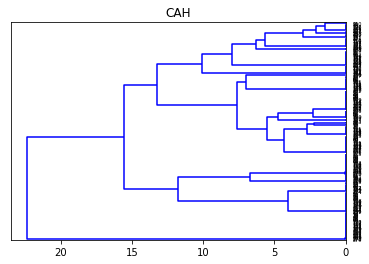

In [35]:
#affichage du dendrogramme
Z = linkage(X_pca["pca"][0],method='ward',metric='euclidean')
plt.title("CAH")
dendrogram(Z,orientation='left',color_threshold=0)
plt.show()

In [41]:
#On calcule pour chaque texte les 10 centres de gravité associés

X_pca["cah"] = X_pca["pca"].apply(cah)
print("done !")
X_test_pca["cah"] = X_test_pca["pca"].apply(cah)
print("done")

#Une sauvegarde des résultats est possible
#X_pca["cah"].to_csv(dire + "dataframe_train_fin.csv")
#X_test_pca["cah"].to_csv(dire + "dataframe_test_fin.csv")

C:\Users\Simon\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


done !
done


## Machine Learning

Nous appliquons donc maintenant un algorithme de Machine Learning prenant en entrée les variables de prédiction précédemment construites

In [42]:
#Préparation des données

y_test = y_test.loc[X_test_pca.index]
y_train = y_train.loc[X_pca.index]

X_train_for_ml = [t for t in X_pca['cah'].as_matrix()]
X_test_for_ml = [t for t in X_test_pca['cah'].as_matrix()]

In [43]:
#Construction et entraînement de l'algorithme

model = RFC(n_estimators = 200,n_jobs = -1)
model.fit(X_train_for_ml,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Analyse des résultats

L'analyse de la prédiction multi-classe (ci-dessous) nous donne des résultats médiocres, par rapport aux résultats obtenus par le preprocessing de type "bag of word". 

In [44]:
#Calcul du score de prédiction multi-classes
model.score(X_test_for_ml,y_test)

0.080966511233573554

En regardant de plus près les matrices de confusion, on s'aperçoit qu'une partie non négligeable des prédicteurs sont des constantes égales à zéro.

In [45]:
#Matrice de confusion et précision (vrais positifs / vrais positifs + faux positifs)
from sklearn.metrics import confusion_matrix
for i in range(22):
    model.fit(X_train_for_ml,y_train[str(i)])
    X_predict = model.predict(X_test_for_ml)
    mat = confusion_matrix(X_predict,y_test[str(i)])
    sco = mat[1,1]/(mat[1,1] + mat[0,1])
    print(i,sco)
    print(mat)

0 0.0781609195402
[[6627  401]
 [  15   34]]
1 0.925690021231
[[ 678  245]
 [3102 3052]]
2 0.279279279279
[[6848  160]
 [   7   62]]
3 0.0714285714286
[[6881  169]
 [  14   13]]
4 0.440797186401
[[5973  477]
 [ 251  376]]
5 0.103879849812
[[5128 1432]
 [ 351  166]]
6 0.0457875457875
[[6472  521]
 [  59   25]]
7 0.0507131537242
[[6376  599]
 [  70   32]]
8 0.0595238095238
[[6902  158]
 [   7   10]]
9 0.0744985673352
[[6648  323]
 [  80   26]]
10 0.155279503106
[[6907  136]
 [   9   25]]
11 0.0501089324619
[[6088  872]
 [  71   46]]
12 0.0625909752547
[[6300  644]
 [  90   43]]
13 0.0737913486005
[[6675  364]
 [   9   29]]
14 0.016393442623
[[6874  180]
 [  20    3]]
15 0.0828025477707
[[6741  288]
 [  22   26]]
16 0.141975308642
[[6908  139]
 [   7   23]]
17 0.0854700854701
[[6685  321]
 [  41   30]]
18 0.110356536503
[[4911 1572]
 [ 399  195]]
19 0.135371179039
[[6838  198]
 [  10   31]]
20 0.014598540146
[[6936  135]
 [   4    2]]
21 0.188841201717
[[6829  189]
 [  15   44]]


# Conclusion

Notre but était de prédire les labels correspondants à chaque texte du corpus du challenge SIAM 2007. Nous avons essayé 2 modélisations de textes différentes, les bag of words et les word2vec, et nous avons essayé 2 méthodes d'application d'algorithme de Machine Learning sur chacune de ces modélisations. Les résultats sont semblables, et faibles, à l'exception des résultats encore plus faibles du Machine Learning avec word2vec, ACP et classification.

Ces résultats peu satisfaisants peuvent s'expliquer par le fait que nous disposons, pour beaucoup de label, que de peu d'échantillons positifs, ce qui rend l'apprentissage difficile.

La dernière méthode, bien que donnant les moins bons résultats, semble être la plus prometteuse dans le sens où l'on peu aller plus loin dans l'optimisation des paramètres.
Ainsi, au lieu de réduire la classification à 10 élèments on pourrait en augmenter le nombre, et on pourrait faire un "mix" de la méthode "word2vec simpliste" et "word2vec, ACP et classification", en entraînant un word2vec sur notre corpus puis en utilisant une ACP et une classification.
